# Your first code using SymPDE & PsyDAC
*Author: Ahmed Ratnani*

We start by writing our first example using SymPDE.
Let $\Omega := (0,1)^2$. We consider the Poisson problem with homogeneous Dirichlet boundary conditions.  

$$
\begin{align}
  - \nabla^2 u = f \quad \text{in $\Omega$}, \quad \quad 
  u = 0            \quad \text{on $\partial \Omega$}. 
\end{align}
$$

## Variational Formulation

An $H^1$-conforming variational formulation of the previous problem reads

$$
\begin{align}
  \text{find $u \in V$ such that} \quad a(u,v) = l(v) \quad \forall v \in V,
\end{align}
$$

where 

- $V \subset H^1_0(\Omega)$, 
- $a(u,v) := \int_{\Omega} \nabla u \cdot \nabla v ~ d\Omega$, 
- $l(v) := \int_{\Omega} f v ~ d\Omega$.

## Formal Model

In [77]:
from sympde.expr import BilinearForm, LinearForm, integral
from sympde.expr     import find, EssentialBC, Norm, SemiNorm
from sympde.topology import ScalarFunctionSpace, Square, element_of
from sympde.calculus import grad, dot
import matplotlib.pyplot as plt
import numpy as np

from sympy import pi, sin, lambdify

domain = Square() # defines unit sq of [0,1] x [0,1]

V = ScalarFunctionSpace('V', domain) # finite element space where galerkin method is applied,
                                     # fxn space for scalar valued functions over the square domain

x,y = domain.coordinates

u,v = [element_of(V, name=i) for i in ['u', 'v']] #trial and test functions 

# bilinear form
a = BilinearForm((u,v), integral(domain , dot(grad(v), grad(u)))) # derived from variational form of pde

# linear form
f = 2*pi**2*sin(pi*x)*sin(pi*y) #rhs function
l = LinearForm(v, integral(domain, f*v)) # from variational form of pde

# Dirichlet boundary conditions
bc = [EssentialBC(u, 0, domain.boundary)]

# Variational problem
equation   = find(u, forall=v, lhs=a(u, v), rhs=l(v), bc=bc)


This very simple Python code reflects well the abstract mathematical framework needed for variational formulations.
The structure of the code is as follows,

1. Create a domain.
2. Create a space of *scalar* functions over the domain.
3. Create elements from this function space. These elements will denote the test and trial functions.
4. Create the Bilinear and Linear forms, $a$ and $l$ respectively.
5. Create Essential Boundary Conditions.
6. Create the variational problem.

Most of the time, you will need to follow the same steps, with some minor variants depending on the problem you're considering.

## Discretization

We shall need the **discretize** function from **PsyDAC**.

In [17]:
from psydac.api.discretization import discretize

In [26]:
degree = [3,3]
p1, p2 = (3,3)
ncells = [16,16]
ne1, ne2 = (16,16)


In [102]:
# Create computational domain from topological domain
domain_h = discretize(domain, ncells=ncells, comm=None)

# Create discrete spline space
Vh = discretize(V, domain_h, degree=degree)

# Discretize equation
equation_h = discretize(equation, domain_h, [Vh, Vh])

## Solving the PDE

In [101]:
# FEM func represented in terms of B spline basis functions
# uh.coeffs -> numerical coefficients of the solution in the b spline space (Vh)(finite subspace of V) 
uh = equation_h.solve()

## Computing the error norm

When the analytical solution is available, you might be interested in computing the $L^2$ norm or $H^1_0$ semi-norm.
SymPDE allows you to do so, by creating the **Norm** object.
In this example, the analytical solution is given by

$$
u_e = \sin(\pi x) \sin(\pi y)
$$

### Computing the $L^2$ norm

In [90]:
ue = sin(pi*x)*sin(pi*y)

u = element_of(V, name='u')
phi_exact = lambdify((x,y),ue,'numpy')
print(phi_exact)
# create the formal Norm object
l2norm = Norm(u - ue, domain, kind='l2')
print(l2norm)

# discretize the norm
l2norm_h = discretize(l2norm, domain_h, Vh)

# assemble the norm
l2_error = l2norm_h.assemble(u=uh)

# print the result
print(l2_error)

<function _lambdifygenerated at 0x7d79b5543400>
Norm(Integral(Square, (u - sin(pi*x1)*sin(pi*x2))**2))
9.49756716724664e-07


### Computing the $H^1$ semi-norm

In [7]:
# create the formal Norm object
h1norm = SemiNorm(u - ue, domain, kind='h1')

# discretize the norm
h1norm_h = discretize(h1norm, domain_h, Vh)

# assemble the norm
h1_error = h1norm_h.assemble(u=uh)

# print the result
print(h1_error)

9.768702410721585e-05


### Computing the $H^1$ norm

In [8]:
# create the formal Norm object
h1norm = Norm(u - ue, domain, kind='h1')

# discretize the norm
h1norm_h = discretize(h1norm, domain_h, Vh)

# assemble the norm
h1_error = h1norm_h.assemble(u=uh)

# print the result
print(h1_error)

9.769164089397408e-05


### Visualization


/tmp/ipykernel_4048/1801382318.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


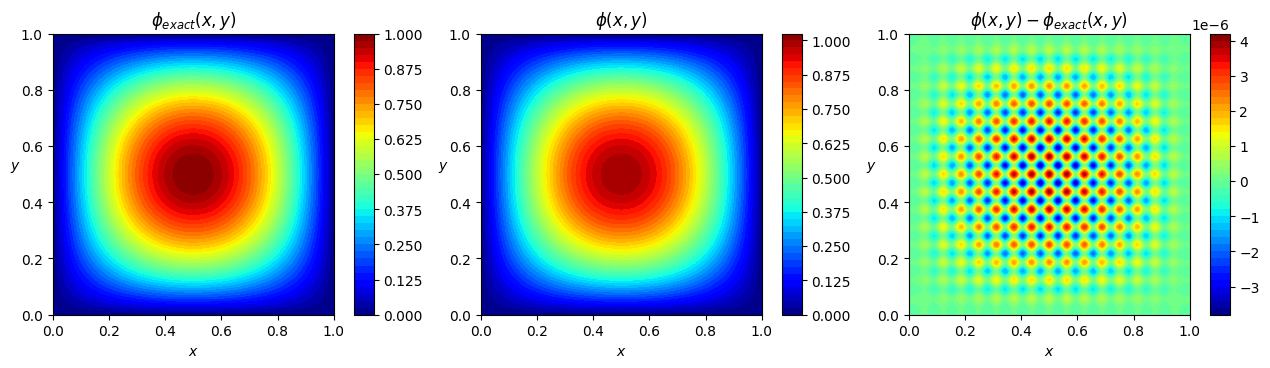

In [104]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

N =10

import numpy as np

def refine_array_1d(breaks, N):
    """Refine a 1D array by inserting N points between each pair of original values."""
    refined = np.concatenate([np.linspace(breaks[i], breaks[i+1], N+1)[:-1] for i in range(len(breaks)-1)])
    return np.append(refined, breaks[-1])  # Add the last point

# Generate refined grid for visualization
eta1 = refine_array_1d(Vh.spaces[0].breaks, N)
eta2 = refine_array_1d(Vh.spaces[1].breaks, N)

# Evaluate numerical solution on the refined grid
num = np.array([[uh(e1, e2) for e2 in eta2] for e1 in eta1])

# Compute exact solution (assuming `phi_exact` is defined)
ex = np.array([[phi_exact(e1, e2) for e2 in eta2] for e1 in eta1])
err = num - ex

# Generate physical grid coordinates (since no mapping, they are just `eta1` and `eta2`)
xx, yy = np.meshgrid(eta1, eta2, indexing='ij')

# Create figure with 3 subplots:
fig, axes = plt.subplots(1, 3, figsize=(12.8, 4.8))

def add_colorbar(im, ax):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=0.2, pad=0.2)
    cbar = ax.get_figure().colorbar(im, cax=cax)
    return cbar

# Plot exact solution
ax = axes[0]
im = ax.contourf(xx, yy, ex, 40, cmap='jet')
add_colorbar(im, ax)
ax.set_xlabel(r'$x$', rotation='horizontal')
ax.set_ylabel(r'$y$', rotation='horizontal')
ax.set_title (r'$\phi_{exact}(x,y)$')
ax.set_aspect('equal')

# Plot numerical solution
ax = axes[1]
im = ax.contourf(xx, yy, num, 40, cmap='jet')
add_colorbar(im, ax)
ax.set_xlabel(r'$x$', rotation='horizontal')
ax.set_ylabel(r'$y$', rotation='horizontal')
ax.set_title (r'$\phi(x,y)$')
ax.set_aspect('equal')

# Plot numerical error
ax = axes[2]
im = ax.contourf(xx, yy, err, 40, cmap='jet')
add_colorbar(im, ax)
ax.set_xlabel(r'$x$', rotation='horizontal')
ax.set_ylabel(r'$y$', rotation='horizontal')
ax.set_title (r'$\phi(x,y) - \phi_{exact}(x,y)$')
ax.set_aspect('equal')

# Show figure
plt.tight_layout()
fig.show()